In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob

import sys, os
# Path to reads
vdj_path = '../data/germline_db_vcall/final/tonsil_vdjs.tsv.gz'
read_path = '../data/vdj/UMI_collapsed_on_tissue_read_list.csv.gz'
follicle_localization_dir = '../data/spatial_metadata/'
follicle_localization_files = glob.glob(follicle_localization_dir + '/section*.csv')


In [13]:
dfs = []
for f in follicle_localization_files:
    section = f.split("/")[-1].split(".")[0]
    
    df = pd.read_csv(f)
    df['library'] = 'TonsilZ_' + section
    df = df.rename(columns={'Barcode':'st_barcode_root','Follicles_seurat':'follicle'})
    dfs.append(df)
df = pd.concat(dfs)
df

,st_barcode_root,follicle,library
0,AAACAAGTATCTCCCA-1,NaN,TonsilZ_section17
1,AAACATTTCCCGGATT-1,NaN,TonsilZ_section17
2,AAACCCGAACGAAATC-1,NaN,TonsilZ_section17
3,AAACCGGAAATGTTAA-1,NaN,TonsilZ_section17
4,AAACCGGGTAGGTACC-1,NaN,TonsilZ_section17
...,...,...,...
2256,TTGTTCAGTGTGCTAC-1,NaN,TonsilZ_section32
2257,TTGTTGTGTGTCAAGA-1,NaN,TonsilZ_section32
2258,TTGTTTCACATCCAGG-1,NaN,TonsilZ_section32
2259,TTGTTTCATTAGTCTA-1,NaN,TonsilZ_section32


In [14]:
vdj_df = pd.read_table(vdj_path)
vdj_df['sequence_id'] = vdj_df['sequence_id'].astype(int)

vdj_df = vdj_df.drop(columns=['quals',
                              'library', 
                              'direction',
                              'st_barcode',
                              'st_umi', 
                              'x_coor',
                              'y_coor',
                              'combined_barcode_umi',
                              'cloneMapping',
                              'cloneId'])

read_info_df = pd.read_csv(read_path, usecols=['readId',
                                 'qual',
                                 'library2',
                                 'direction',
                                 'st_barcode',
                                 'st_umi',
                                 'y_coor',
                                 'x_coor',
                                 'combined_barcode_umi',
                                 'cseq',
                                 'cloneMapping',
                                 'cloneId'])

read_info_df = read_info_df.rename(columns={'readId':'sequence_id',
                                            'qual':'quals',
                                            'library2':'library'})


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_49134/3545946006.py:1: DtypeWarning: Columns (10,26,27,28,29,56,92,94,96,97,98,99,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  vdj_df = pd.read_table(vdj_path)


In [15]:
vdj_df = vdj_df.merge(read_info_df, on=['sequence_id'], how='left')

In [16]:
vdj_df['st_barcode_root'] = vdj_df['st_barcode'].str.split('_').str[0]

In [21]:
vdj_df = vdj_df.merge(df, on=['st_barcode_root', 'library'], how='left')

follicle
EF        206961
Foll1       3386
Foll10      2046
Foll11       846
Foll12       282
Foll13       107
Foll14       580
Foll15       136
Foll16      1229
Foll17       576
Foll18       639
Foll19      1093
Foll2        685
Foll20       336
Foll21       115
Foll22       264
Foll23       890
Foll24       361
Foll25       735
Foll26       242
Foll27      1304
Foll28       291
Foll29       489
Foll3        136
Foll30       130
Foll31        29
Foll32      1451
Foll33      1075
Foll34       484
Foll35        21
Foll36        76
Foll37       355
Foll4        806
Foll5         91
Foll6        306
Foll7        701
Foll8        144
Foll9        146
dtype: int64


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_49134/3799717814.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


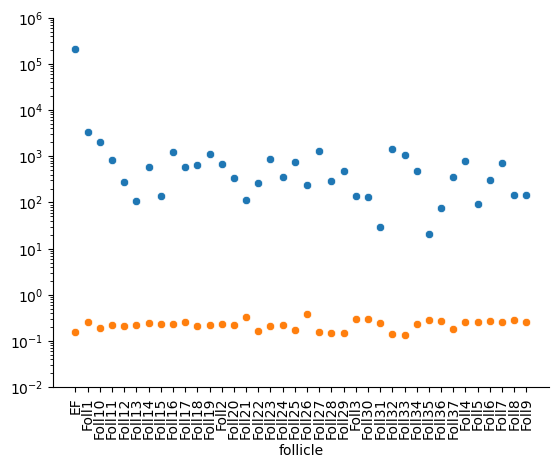

In [51]:
vdj_df.follicle = vdj_df.follicle.fillna('EF')

fig, ax = plt.subplots()
total_count = vdj_df.groupby('follicle').size()
print(total_count)
sns.scatterplot(total_count, ax = ax)
ax.set_yscale('log')

heavy_count = vdj_df[vdj_df.locus=='IGH'].groupby('follicle').size()

heavy_fraction = heavy_count/total_count

sns.scatterplot(heavy_fraction, color='C1')
ax.set_ylim([0.01,10**6])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yscale('log')
sns.despine(fig)


In [20]:
df.library.value_counts()

TonsilZ_section16    2522
TonsilZ_section12    2521
TonsilZ_section17    2501
TonsilZ_section22    2488
TonsilZ_section31    2327
TonsilZ_section32    2261
Name: library, dtype: int64

In [53]:
vdj_df['vdj_sequence'] = vdj_df.apply(lambda x: x.sequence[int(x.v_sequence_start)-1:int(x.j_sequence_end)], axis=1)

In [61]:
unique_vdjs_per_follicle = vdj_df[vdj_df.locus=='IGH'].groupby('follicle')['vdj_sequence'].nunique()
unique_lineages_per_follicle = vdj_df[vdj_df.locus=='IGH'].groupby('follicle')['lineage_id'].nunique()

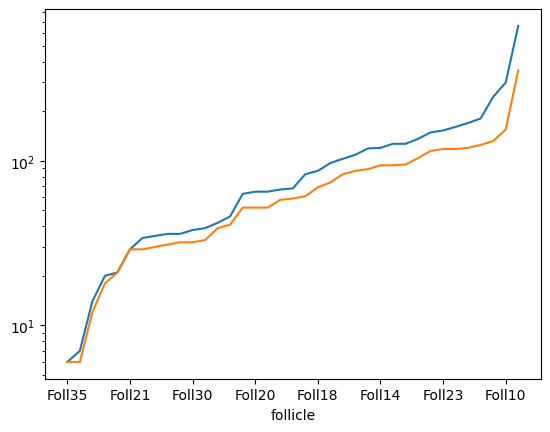

In [62]:
unique_vdjs_per_follicle[unique_vdjs_per_follicle.index != 'EF'].sort_values().plot()
unique_lineages_per_follicle[unique_lineages_per_follicle.index != 'EF'].sort_values().plot()
plt.yscale('log')

In [72]:
vdj_df['EF'] = vdj_df.follicle == 'EF'
vdjs_per_lineage = vdj_df.groupby(['EF','locus', 'lineage_id'])['vdj_sequence'].nunique()
vdjs_per_lineage = vdjs_per_lineage.reset_index()


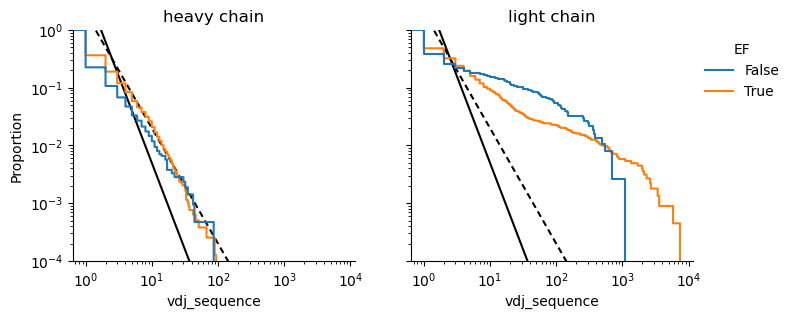

In [78]:

fig, ax = plt.subplots(1,2,sharex=True, sharey=True, figsize=(8,3))
for i in [0,1]:
    ax[i].plot(np.logspace(0,3), np.logspace(0,3)**-3*5, color='k', label =r'$n^{-3}$')
    line1,  = ax[i].plot(np.logspace(0,3), np.logspace(0,3)**-2*2, color='k', label=r'$n^{-2}$')
    line1.set_dashes((3,2))
ax[0].set_ylim([10**-4,1])
ax[0].set_title('heavy chain')
sns.ecdfplot(vdjs_per_lineage[vdjs_per_lineage.locus=='IGH'], 
                x ='vdj_sequence', 
                hue='EF', 
                complementary='True', 
                log_scale=(True, True), 
                ax =ax[0], 
                legend=False)
ax[1].set_title('light chain')
g = sns.ecdfplot(vdjs_per_lineage[vdjs_per_lineage.locus!='IGH'], x ='vdj_sequence', hue='EF', complementary='True', log_scale=(True, True), ax = ax[1])
sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
sns.despine(fig)



In [88]:
vdj_df['EF'] = vdj_df.follicle == 'EF'
n_follicles = vdj_df.groupby('lineage_id')['follicle'].nunique()

vdjs_per_lineage = vdj_df.groupby(['EF','locus', 'lineage_id'])['vdj_sequence'].nunique()
vdjs_per_lineage = vdjs_per_lineage.reset_index()

vdjs_per_lineage['n_follicles'] = vdjs_per_lineage.lineage_id.map(n_follicles)

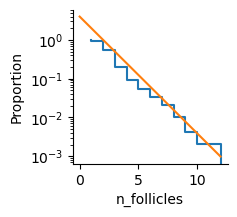

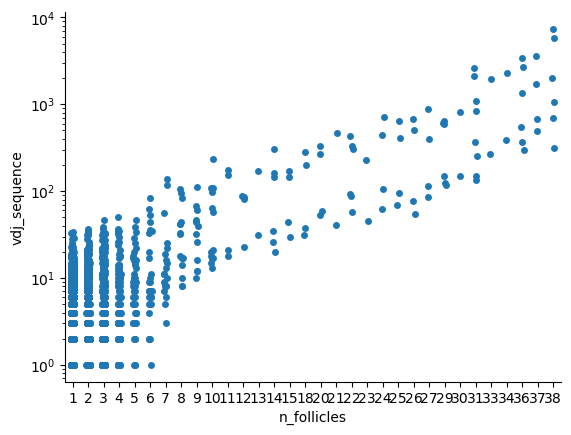

In [109]:
IGH = vdjs_per_lineage.locus == 'IGH'
IF = ~(vdjs_per_lineage.EF.astype(bool))
IGH_IF = IGH&IF

fig, ax = plt.subplots(figsize=(2,2))

sns.ecdfplot(vdjs_per_lineage[(vdjs_per_lineage['vdj_sequence'] > 1)&IGH_IF],
             x='n_follicles',
            complementary=True,
            log_scale=(False, True))
sns.despine(fig)

xs = np.linspace(0,12,100)
ax.plot(xs, 4*0.5**xs)

fig, ax = plt.subplots()

sns.stripplot(vdjs_per_lineage, x = 'n_follicles', y='vdj_sequence')
ax.set_yscale('log')
sns.despine(fig)

In [ ]:
IGH = vdjs_per_lineage.locus == 'IGH'
IF = ~(vdjs_per_lineage.EF.astype(bool))
IGH_IF = IGH&IF

fig, ax = plt.subplots(figsize=(2,2))

sns.ecdfplot(vdjs_per_lineage[(vdjs_per_lineage['vdj_sequence'] > 1)&IGH_IF],
             x='n_follicles',
            complementary=True,
            log_scale=(False, True))
sns.despine(fig)

xs = np.linspace(0,12,100)
ax.plot(xs, 4*0.5**xs)



Text(0.5, 1.0, 'light chain')

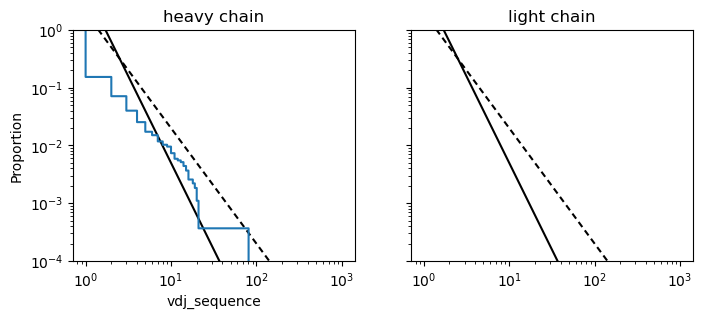

In [81]:

fig, ax = plt.subplots(1,2,sharex=True, sharey=True, figsize=(8,3))
for i in [0,1]:
    ax[i].plot(np.logspace(0,3), np.logspace(0,3)**-3*5, color='k', label =r'$n^{-3}$')
    line1,  = ax[i].plot(np.logspace(0,3), np.logspace(0,3)**-2*2, color='k', label=r'$n^{-2}$')
    line1.set_dashes((3,2))
ax[0].set_ylim([10**-4,1])
ax[0].set_title('heavy chain')
sns.ecdfplot(vdjs_per_lineage[(vdjs_per_lineage.locus=='IGH')&(vdjs_per_lineage.EF==False)], 
                x ='vdj_sequence', 
                complementary='True', 
                log_scale=(True, True), 
                ax =ax[0], 
                legend=False)
ax[1].set_title('light chain')



(0.0001, 1)

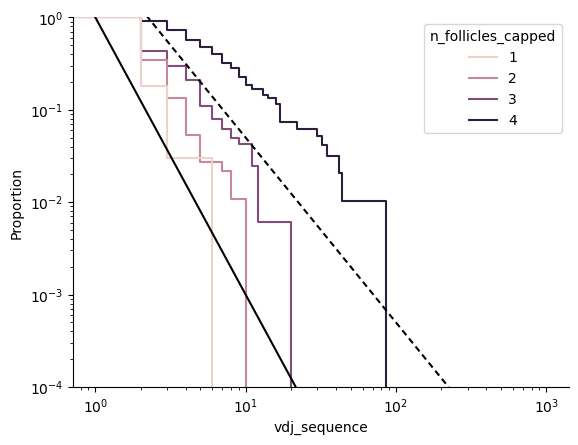

In [116]:

vdjs_per_lineage['n_follicles_capped'] = vdjs_per_lineage.n_follicles.map(lambda x: min(x, 4))
fig, ax = plt.subplots()
sns.ecdfplot(vdjs_per_lineage[(vdjs_per_lineage['vdj_sequence'] > 1)&IGH_IF],
             x='vdj_sequence',
             hue = 'n_follicles_capped',
            complementary=True,
            log_scale=(True, True))
sns.despine(fig)

xs = np.logspace(0,3,50)
ax.plot(xs, xs**-3, color='k')
line1,  = ax.plot(xs, 5*xs**-2, color='k')
line1.set_dashes((3,2))
ax.set_ylim([10**-4,1])
